In [17]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


Displaying original banknote images with bounding boxes

In [18]:
def load_image(image_path):
    """Load an image from the specified path."""
    return Image.open(image_path)

def parse_xml_annotation(xml_file):
    """Parse the Pascal VOC XML file to extract bounding boxes and labels."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text 
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        bboxes.append((class_name, xmin, ymin, xmax, ymax))
    
    return bboxes, class_name

def draw_bboxes_on_image(image, bboxes):
    """Draw bounding boxes and labels on the image."""
    draw = ImageDraw.Draw(image)
    
    for (class_name, xmin, ymin, xmax, ymax) in bboxes:
        # Draw the bounding box
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
    
    return image

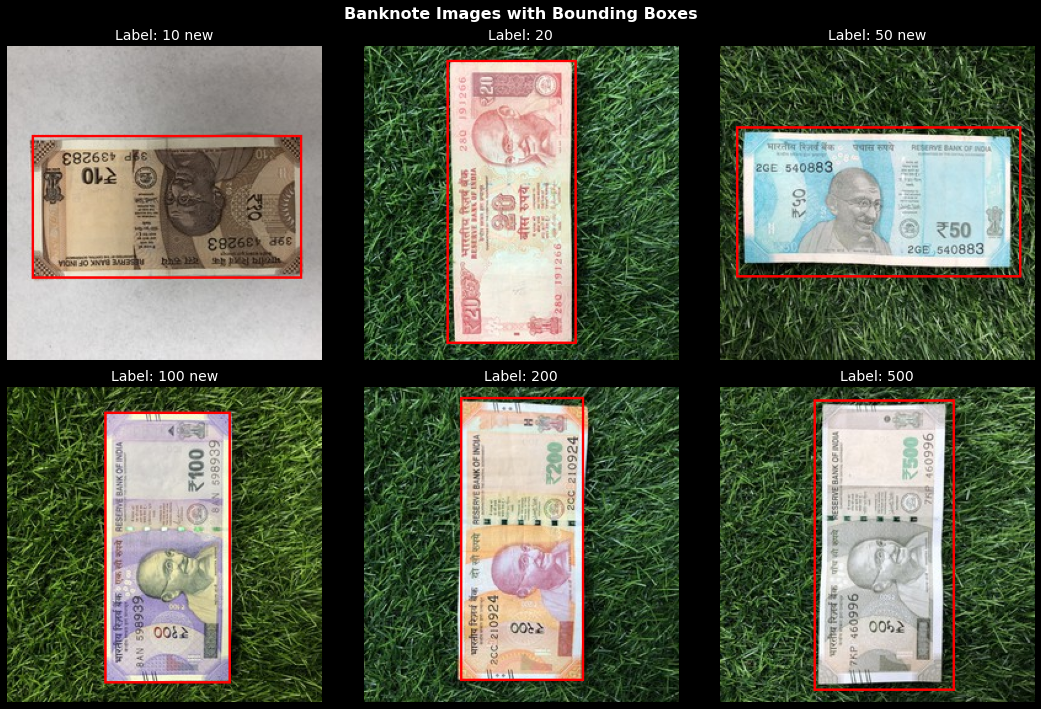

In [19]:
image_path_list = ["Data/New/10 New/INDIA10NEW_146.jpg", 
                   "Data/New/20/INDIA20_1.jpg", 
                   "Data/New/50 New/INDIA50NEW_1.jpg",
                   "Data/New/100 New/INDIA100NEW_1.jpg",
                   "Data/New/200/INDIA200_1.jpg",
                   "Data/New/500/INDIA500_1.jpg"]

xml_path_list = ["Data/New/10 New/INDIA10NEW_146.xml", 
                   "Data/New/20/INDIA20_1.xml", 
                   "Data/New/50 New/INDIA50NEW_1.xml",
                   "Data/New/100 New/INDIA100NEW_1.xml",
                   "Data/New/200/INDIA200_1.xml",
                   "Data/New/500/INDIA500_1.xml"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.patch.set_facecolor('black')
axes_flatten = axes.flatten()

for index in range(len(image_path_list)):
    image_path, xml_path, ax = image_path_list[index], xml_path_list[index], axes_flatten[index]

    image = load_image(image_path)
    bboxes, class_name = parse_xml_annotation(xml_path)
    image_with_bboxes = draw_bboxes_on_image(image, bboxes)

    ax.set_title(f"Label: {class_name}", fontsize=14, color = "white")
    ax.imshow(image_with_bboxes)
    ax.axis('off')

fig.suptitle('Banknote Images with Bounding Boxes', fontsize=16, fontweight='bold', color = "white")

plt.tight_layout()
plt.show()

Displaying a sample of the cropped banknotes

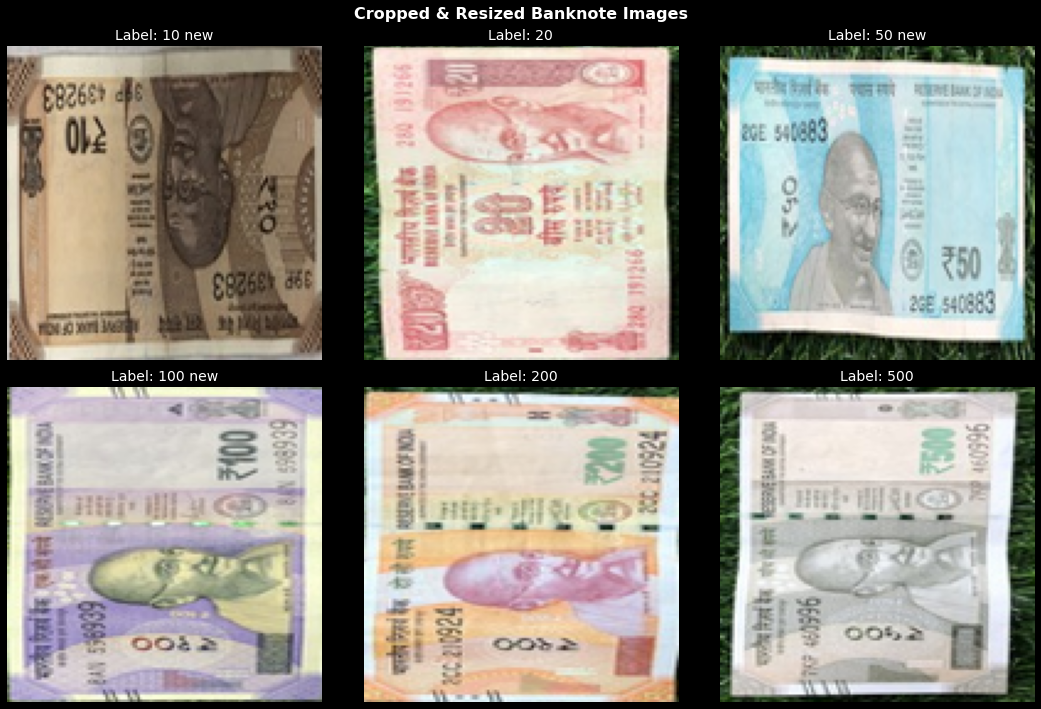

In [20]:
def crop_image(image, bbox):
    """Crop the image using the bounding box coordinates."""
    class_name, xmin, ymin, xmax, ymax = bbox[0]
    cropped_image = image.crop((xmin, ymin, xmax, ymax))
    
    return cropped_image

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.patch.set_facecolor('black')
axes_flatten = axes.flatten()

for index in range(len(image_path_list)):
    image_path, xml_path, ax = image_path_list[index], xml_path_list[index], axes_flatten[index]

    image = load_image(image_path)
    bboxes, class_name = parse_xml_annotation(xml_path)
    cropped_image = crop_image(image, bboxes)
    resized_image = cropped_image.resize((128, 128))

    ax.set_title(f"Label: {class_name}", fontsize=14, color = "white")
    ax.imshow(resized_image)
    ax.axis('off')

fig.suptitle('Cropped & Resized Banknote Images', fontsize=16, fontweight='bold', color = "white")

plt.tight_layout()
plt.show()

In [21]:
class CurrencyDataset(Dataset):

    def __init__(self, image_dirs, transform=None, test_transform=None, class_mapping=None, test_split = 0.2):
        """
        Args:
            image_dirs (list): List of directories containing images and XML files.
            transform (callable, optional): Optional transform to be applied on an image.
            test_transform (callable, optional): Optional transform for testing images.
            target_transform (callable, optional): Optional transform for target labels.
        """
        self.image_paths = []
        self.targets = []
        self.num_classes = len(class_mapping.keys())

        # Load images and XML files from each directory
        for image_dir in image_dirs:
            for filename in os.listdir(image_dir):
                if filename.endswith('.jpg'):  
                    image_path = os.path.join(image_dir, filename)
                    xml_path = os.path.join(image_dir, filename.replace('.jpg', '.xml'))

                    self.image_paths.append(image_path)
                    class_name, bboxes = self.parse_xml(xml_path)
                    self.targets.append((class_name, bboxes))

        # Combine paths and targets into a single dataset
        self.data = list(zip(self.image_paths, self.targets))

        # Create a dictionary to store data by class
        class_dict = {}
        for image_path, (class_name, bboxes) in self.data:
            if class_name not in class_dict:
                class_dict[class_name] = []
            class_dict[class_name].append((image_path, bboxes))

        self.train_images = []
        self.train_targets = []
        self.test_images = []
        self.test_targets = []

        # Split dataset class-wise (80:20)
        for class_name, instances in class_dict.items():
            train_data, test_data = train_test_split(instances, test_size= test_split, random_state=42)
            self.train_images.extend([img for img, _ in train_data])
            self.train_targets.extend([(class_name, bboxes) for _, bboxes in train_data])
            self.test_images.extend([img for img, _ in test_data])
            self.test_targets.extend([(class_name, bboxes) for _, bboxes in test_data])

        self.transform = transform
        self.test_transform = test_transform
        self.class_mapping = class_mapping

    def parse_xml(self, xml_path):
        """Parse XML file and return the class name and bounding boxes."""
        tree = ET.parse(xml_path)
        root = tree.getroot()

        class_name = None
        bboxes = []

        for obj in root.iter('object'):
            class_name = obj.find('name').text  
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes.append((xmin, ymin, xmax, ymax))  

        return class_name, bboxes

    def crop_image(self, image, bbox):
        """Crop the image based on the bounding box."""
        xmin, ymin, xmax, ymax = bbox
        return image.crop((xmin, ymin, xmax, ymax))

    def __len__(self):
        return len(self.train_images)

    def __getitem__(self, idx):
        image_path = self.train_images[idx]
        class_name, bboxes = self.train_targets[idx]

        image = Image.open(image_path)
        cropped_image = self.crop_image(image, bboxes[0])

        # Apply transformations
        if self.transform:
            cropped_image = self.transform(cropped_image)

        if self.target_transform:
            class_name = self.target_transform(class_name)

        return (cropped_image, class_name)

    def get_test_data(self):
        """Get the test data."""
        test_data = []
        for idx in range(len(self.test_images)):
            image_path = self.test_images[idx]
            class_name, bboxes = self.test_targets[idx]
            image = Image.open(image_path)
            cropped_image = self.crop_image(image, bboxes[0])  

            if self.test_transform:
                cropped_image = self.test_transform(cropped_image)

            if self.target_transform:
                class_name = self.target_transform(class_name)

            test_data.append((cropped_image, class_name))
            
        return test_data
    
    def target_transform(self, class_name):
        return self.class_mapping[class_name]

Calculating mean, standard deviation of images

In [22]:
image_dirs = [
    "Data/New/10 New",
    "Data/New/20",
    "Data/New/50 New",
    "Data/New/100 New",
    "Data/New/200",
    "Data/New/500"
]

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class_mapping = {
    "10 new" : 0,
    "20" : 1,
    "50 new" : 2,
    "100 new" : 3,
    "200" : 4,
    "500" : 5
}

dataset = CurrencyDataset(image_dirs, train_transform, None, class_mapping, 0.1)
loader = DataLoader(dataset, batch_size = 32)

mean = 0.
std = 0.
nb_samples = 0.
for data, target in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(mean, std)
print(f"Number of samples in training dataset = {nb_samples}")

tensor([0.6295, 0.5977, 0.5551]) tensor([0.2069, 0.1965, 0.2004])
Number of samples in training dataset = 252.0


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_mapping = {
    "10 new" : 0,
    "20" : 1,
    "50 new" : 2,
    "100 new" : 3,
    "200" : 4,
    "500" : 5
}

image_dirs = [
    "Data/New/10 New",
    "Data/New/20",
    "Data/New/50 New",
    "Data/New/100 New",
    "Data/New/200",
    "Data/New/500"
]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6295, 0.5977, 0.5551], std=[0.2069, 0.1965, 0.2004])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6295, 0.5977, 0.5551], std=[0.2069, 0.1965, 0.2004])
])

num_classes = len(class_mapping.keys())

device

device(type='cpu')

In [24]:
currency_dataset = CurrencyDataset(image_dirs = image_dirs, 
                                   transform=train_transform, 
                                   test_transform=test_transform, 
                                   class_mapping=class_mapping,
                                   test_split=0.2)

In [25]:
train_loader = DataLoader(currency_dataset, batch_size=32, shuffle=True)
test_dataset = currency_dataset.get_test_data()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [26]:
mobilenet = models.mobilenet_v2(weights = 'DEFAULT')

In [27]:
in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = torch.nn.Linear(in_features, num_classes)

for param in mobilenet.parameters():
    param.requires_grad = False

# Only the parameters of the classifier will be updated during training
for param in mobilenet.classifier.parameters():
    param.requires_grad = True

In [28]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_fcn = torch.nn.CrossEntropyLoss()

    correct, total = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  
        output = model(data)  
        loss = loss_fcn(output, target)  

        pred = output.max(1, keepdim = True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += int(len(target))

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        optimizer.zero_grad()  
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
            epoch + 1, total, len(train_loader.dataset),
            100. * (batch_idx + 1) / len(train_loader), loss.item(), correct/total))

In [29]:
def get_accuracy(model, dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))

    correct, total = 0, 0
    for data, target in loader:
        output = model(data)
        pred = output.max(1, keepdim = True)[1]

        correct += pred.eq(target.view_as(pred)).sum().item()
        total += int(len(target))

    return correct/total

In [30]:
model = mobilenet.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

best_accuracy = 0

for epoch in range(20):
    train(mobilenet, device, train_loader, optimizer, epoch)
    train_accuracy, test_accuracy = get_accuracy(model, currency_dataset), get_accuracy(model, test_dataset)
    print(f"Train Accuracy = {train_accuracy}")
    print(f"Test Accuracy = {test_accuracy}")

    if best_accuracy < test_accuracy:
        torch.save(model.state_dict(), "model.pt")
        best_accuracy = test_accuracy
        print(f'Saved new best model with accuracy: {best_accuracy:.2f}')


Train Epoch: 1 [32/224 (14%)]	Loss: 1.823743	Accuracy: 0.16
Train Epoch: 1 [64/224 (29%)]	Loss: 1.524778	Accuracy: 0.31
Train Epoch: 1 [96/224 (43%)]	Loss: 1.468507	Accuracy: 0.32
Train Epoch: 1 [128/224 (57%)]	Loss: 1.108904	Accuracy: 0.43
Train Epoch: 1 [160/224 (71%)]	Loss: 1.012433	Accuracy: 0.49
Train Epoch: 1 [192/224 (86%)]	Loss: 1.030238	Accuracy: 0.53
Train Epoch: 1 [224/224 (100%)]	Loss: 0.969344	Accuracy: 0.55
Train Accuracy = 0.90625
Test Accuracy = 0.8813559322033898
Saved new best model with accuracy: 0.88
Train Epoch: 2 [32/224 (14%)]	Loss: 0.791011	Accuracy: 0.88
Train Epoch: 2 [64/224 (29%)]	Loss: 0.598694	Accuracy: 0.92
Train Epoch: 2 [96/224 (43%)]	Loss: 0.528442	Accuracy: 0.93
Train Epoch: 2 [128/224 (57%)]	Loss: 0.503140	Accuracy: 0.95
Train Epoch: 2 [160/224 (71%)]	Loss: 0.466724	Accuracy: 0.94
Train Epoch: 2 [192/224 (86%)]	Loss: 0.472718	Accuracy: 0.93
Train Epoch: 2 [224/224 (100%)]	Loss: 0.438529	Accuracy: 0.92
Train Accuracy = 0.9330357142857143
Test Accuracy

In [31]:
def evaluate_and_plot_confusion_matrix(model, device, dataset, class_names):
    loader = DataLoader(dataset, batch_size=len(dataset))

    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            pred = output.max(1, keepdim = True)[1]

            all_preds.append(pred.cpu().numpy().reshape(-1).astype(int))
            all_labels.append(target.cpu().numpy().astype(int))

    all_preds = np.array(np.concatenate(all_preds))
    all_labels = np.array(np.concatenate(all_labels))

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.4f}%")

    cm = confusion_matrix(all_labels, all_preds)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    print("\nClassification Report:")
    print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-score':<10}")
    for label, metrics in report.items():
        if label in class_names:
            print(f"{label:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}")


Overall Accuracy: 94.9153%


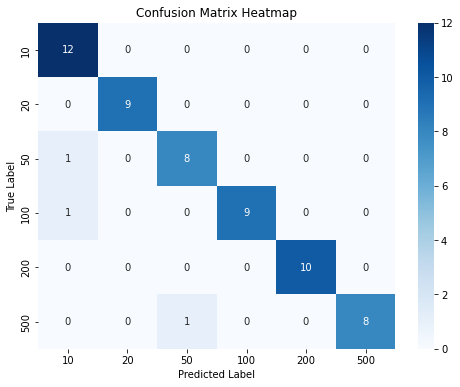


Classification Report:
Class          Precision Recall    F1-score  
10             0.8571    1.0000    0.9231    
20             1.0000    1.0000    1.0000    
50             0.8889    0.8889    0.8889    
100            1.0000    0.9000    0.9474    
200            1.0000    1.0000    1.0000    
500            1.0000    0.8889    0.9412    


In [32]:
model = mobilenet
model.load_state_dict(torch.load("model.pt", weights_only=True))
model = model.to(device)

class_names = ["10", "20", "50", "100", "200", "500"]  # Your actual class names
evaluate_and_plot_confusion_matrix(model, device, test_dataset, class_names)